# Run All UDA Experiments (ME-IIS + Fair Baselines)

This notebook runs **source-only**, **ME-IIS**, and fair UDA baselines (**DANN**, **CORAL**, optional **pseudo-label self-training**) with:
- deterministic `run_id` + run directories under `outputs/runs/...`
- **skip/resume** (no redundant retraining)
- unified evaluation + `metrics.csv` per run
- QUICK mode (seed=[0]) and FULL mode (seed list)


## 1) Setup (clone + install)


In [9]:
import os, sys, subprocess
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules
REPO_URL = os.getenv("REPO_URL", "https://github.com/kaminglui/ME-IIS.git")
REPO_DIR = Path(os.getenv("REPO_DIR", "/content/ME-IIS" if IN_COLAB else Path.cwd())).expanduser()
PULL_LATEST = True

if IN_COLAB:
    try:
        from google.colab import drive  # type: ignore
        if os.getenv("MOUNT_DRIVE", "0") == "1":
            drive.mount("/content/drive")
    except Exception as exc:
        print("[Drive] Skipping Drive mount:", exc)

if not REPO_DIR.exists():
    REPO_DIR.parent.mkdir(parents=True, exist_ok=True)
    subprocess.run(["git", "clone", REPO_URL, str(REPO_DIR)], check=True)
else:
    print(f"[Repo] Using existing repo at {REPO_DIR}")
    if PULL_LATEST:
        try:
            subprocess.run(["git", "pull", "--ff-only"], cwd=REPO_DIR, check=True)
        except subprocess.CalledProcessError as exc:
            print("[Repo][WARN] git pull failed (keeping existing checkout):", exc)

os.chdir(REPO_DIR)
print("[Repo] CWD:", Path.cwd())
try:
    sha = subprocess.check_output(["git", "rev-parse", "HEAD"]).decode().strip()
    print("[Repo] HEAD:", sha)
except Exception as exc:
    print("[Repo][WARN] Could not read git sha:", exc)


[Repo] Using existing repo at /content/ME-IIS
[Repo] CWD: /content/ME-IIS
[Repo] HEAD: 4b762db1c448cd4c95f98ed4e62793aa25230f53


In [10]:
import os, sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules
if not IN_COLAB:
    print("[Drive] Not in Colab; skipping Drive mount.")
else:
    from google.colab import drive  # type: ignore

    mount_point = Path("/content/drive")
    drive.mount(str(mount_point))

    drive_root = mount_point / "MyDrive"
    if not drive_root.exists():
        raise RuntimeError("[Drive][ERROR] Mount completed but /content/drive/MyDrive is missing.")

    probe_dir = drive_root / "ME-IIS"
    probe_dir.mkdir(parents=True, exist_ok=True)
    probe_path = probe_dir / "_drive_probe.txt"
    probe_path.write_text("ok\n", encoding="utf-8")
    if probe_path.read_text(encoding="utf-8").strip() != "ok":
        raise RuntimeError("[Drive][ERROR] Drive probe file readback failed.")
    print("[Drive] OK:", probe_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Drive] OK: /content/drive/MyDrive/ME-IIS


In [11]:
import sys, subprocess

subprocess.run([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"], check=True)


CompletedProcess(args=['/usr/bin/python3', '-m', 'pip', 'install', '-r', 'requirements.txt'], returncode=0)

## 2) Config (single cell)


In [12]:
import os, sys
from pathlib import Path

# Dataset (single place to edit)
DATASET_NAME = "office_home"  # office_home | office31
DATA_ROOT = ""  # optional path; leave blank to auto-download

# Optional: override via env vars (Colab-friendly)
DATASET_NAME = os.getenv("DATASET_NAME", DATASET_NAME)
DATA_ROOT = os.getenv("DATA_ROOT", DATA_ROOT)

# Persist datasets + runs to Google Drive in Colab.
IN_COLAB = "google.colab" in sys.modules
USE_DRIVE = IN_COLAB
if USE_DRIVE:
    DRIVE_ROOT = Path("/content/drive/MyDrive")
    if not DRIVE_ROOT.exists():
        raise RuntimeError(
            "[Drive][ERROR] Expected /content/drive/MyDrive to exist. "
            "Run the Drive mount cell first and confirm it prints '[Drive] OK'."
        )
    PERSIST_ROOT = DRIVE_ROOT / "ME-IIS"
    PERSIST_ROOT.mkdir(parents=True, exist_ok=True)
    if not str(DATA_ROOT).strip():
        if DATASET_NAME == "office_home":
            DATA_ROOT = str(PERSIST_ROOT / "datasets" / "Office-Home")
        elif DATASET_NAME == "office31":
            DATA_ROOT = str(PERSIST_ROOT / "datasets" / "Office-31")
        else:
            raise ValueError(f"Unknown DATASET_NAME={DATASET_NAME}")
    RUNS_ROOT = PERSIST_ROOT / "outputs" / "runs"
else:
    RUNS_ROOT = Path("outputs") / "runs"

# Mode
MODE = "FULL"  # QUICK | FULL
FORCE_RERUN = False

# Task
SOURCE_DOMAIN = "Ar"  # Office-Home: Ar/Cl/Pr/Rw ; Office-31: A/D/W
TARGET_DOMAIN = "Cl"

# Seeds
SEEDS = [0] if MODE == "QUICK" else [0, 1, 2]
DETERMINISTIC = True

# Training budget (fair across methods)
EPOCHS_SOURCE = 2 if MODE == "QUICK" else 50
EPOCHS_ADAPT = 2 if MODE == "QUICK" else 10
BATCH_SIZE = 16 if MODE == "QUICK" else 32
NUM_WORKERS = 2 if MODE == "QUICK" else 4

# Optimizer schedule
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-3
LR_BACKBONE = 1e-3
LR_CLASSIFIER = 1e-2

# Adaptation optimizer schedule (shared)
FINETUNE_BACKBONE = False
BACKBONE_LR_SCALE = 0.1
CLASSIFIER_LR_ADAPT = 1e-2

# Optional speed limits (keep 0 for real runs)
DRY_RUN_MAX_SAMPLES = 0
DRY_RUN_MAX_BATCHES = 0

# Where to store outputs.

# ME-IIS params
ME_IIS_PARAMS = {
    "feature_layers": ["layer3", "layer4"],
    "num_latent_styles": 5,
    "components_per_layer": None,
    "cluster_backend": "gmm",  # gmm | vmf_softmax
    "gmm_selection_mode": "bic",  # fixed | bic
    "gmm_bic_min_components": 2,
    "gmm_bic_max_components": 8,
    "vmf_kappa": 20.0,
    "cluster_clean_ratio": 1.0,
    "kmeans_n_init": 10,
    "source_prob_mode": "softmax",  # softmax | onehot
    "iis_iters": 5 if MODE == "QUICK" else 15,
    "iis_tol": 1e-3,
    "use_pseudo_labels": False,
    "pseudo_conf_thresh": 0.9,
    "pseudo_max_ratio": 1.0,
    "pseudo_loss_weight": 1.0,
}

# DANN params
DANN_PARAMS = {
    "disc_hidden_dim": 1024,
    "disc_dropout": 0.0,
    "dann_lambda_schedule": "grl",  # grl | linear | constant
    "domain_loss_weight": 1.0,
}

# CORAL params
CORAL_PARAMS = {
    "feature_layers": ["layer3", "layer4"],
    "coral_weight": 1.0,
}

# Pseudo-label baseline params
PL_PARAMS = {
    "pseudo_conf_thresh": 0.9,
    "pseudo_max_ratio": 1.0,
    "pseudo_loss_weight": 1.0,
}

print("[CFG] MODE:", MODE)
print("[CFG] DATASET_NAME:", DATASET_NAME)
print("[CFG] DATA_ROOT:", DATA_ROOT)
print("[CFG] TASK:", f"{SOURCE_DOMAIN} -> {TARGET_DOMAIN}")
print("[CFG] SEEDS:", SEEDS)
print("[CFG] RUNS_ROOT:", RUNS_ROOT)


[CFG] MODE: FULL
[CFG] DATASET_NAME: office_home
[CFG] DATA_ROOT: /content/drive/MyDrive/ME-IIS/datasets/Office-Home
[CFG] TASK: Ar -> Cl
[CFG] SEEDS: [0, 1, 2]
[CFG] RUNS_ROOT: /content/drive/MyDrive/ME-IIS/outputs/runs


## 3) Data (download/verify)

Supports `office_home` and `office31`.
- Leave `DATA_ROOT` blank to auto-download (KaggleHub).
- If you already have the dataset (or in Drive), set `DATA_ROOT` in the config cell.


In [13]:
import sys
import shutil
from pathlib import Path


def _find_office_home_root(base: Path) -> Path:
    real_candidates = ["RealWorld", "Real World", "Real_World", "Real"]
    candidates = [base] + [p for p in base.rglob("*") if p.is_dir()]
    for cand in candidates:
        if all((cand / sub).exists() for sub in ["Art", "Clipart", "Product"]) and any((cand / r).exists() for r in real_candidates):
            return cand
    return base


def _find_office31_root(base: Path) -> Path:
    candidates = [base] + [p for p in base.rglob("*") if p.is_dir()]
    for cand in candidates:
        names = {p.name.lower() for p in cand.iterdir() if p.is_dir()}
        if {"amazon", "dslr", "webcam"} <= names:
            return cand
    return base


def _download_via_kagglehub(dataset_name: str) -> Path:
    try:
        import kagglehub  # type: ignore
    except ImportError:
        import sys, subprocess

        subprocess.run([sys.executable, "-m", "pip", "install", "kagglehub"], check=True)
        import kagglehub  # type: ignore

    if dataset_name == "office_home":
        raw = Path(kagglehub.dataset_download("lhrrraname/officehome"))
        return _find_office_home_root(raw)
    if dataset_name == "office31":
        raw = Path(kagglehub.dataset_download("xixuhu/office31"))
        return _find_office31_root(raw)
    raise ValueError(f"Unknown DATASET_NAME={dataset_name}")


IN_COLAB = "google.colab" in sys.modules
drive_root = Path("/content/drive/MyDrive")

data_root_str = str(DATA_ROOT).strip()
data_root_path = Path(data_root_str).expanduser() if data_root_str else None

if data_root_path is None:
    print("[Data] DATA_ROOT not set; downloading via KaggleHub...")
    data_root_path = _download_via_kagglehub(DATASET_NAME)
else:
    # If the user points DATA_ROOT to Drive but it's missing, download to runtime and copy to Drive.
    is_drive_path = IN_COLAB and drive_root.exists() and str(data_root_path).replace("\\", "/").startswith("/content/drive/")
    if is_drive_path and not data_root_path.exists():
        print(f"[Data] DATA_ROOT on Drive does not exist yet: {data_root_path}")
        print("[Data] Downloading via KaggleHub to runtime, then copying to Drive...")
        tmp_root = _download_via_kagglehub(DATASET_NAME)
        data_root_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.copytree(tmp_root, data_root_path, dirs_exist_ok=True)

    # Be forgiving if the user points to a parent directory.
    if DATASET_NAME == "office_home":
        expected = ["Art", "Clipart", "Product"]
        if not all((data_root_path / sub).exists() for sub in expected):
            data_root_path = _find_office_home_root(data_root_path)
    elif DATASET_NAME == "office31":
        expected = ["amazon", "dslr", "webcam"]
        names = {p.name.lower() for p in data_root_path.iterdir() if p.is_dir()} if data_root_path.exists() else set()
        if not set(expected) <= names:
            data_root_path = _find_office31_root(data_root_path)

DATA_ROOT = Path(data_root_path).resolve()
print("[Data] DATASET_NAME:", DATASET_NAME)
print("[Data] DATA_ROOT:", DATA_ROOT)
print("[Data] Exists:", DATA_ROOT.exists())


[Data] DATA_ROOT on Drive does not exist yet: /content/drive/MyDrive/ME-IIS/datasets/Office-Home
[Data] Downloading via KaggleHub to runtime, then copying to Drive...
[Data] DATASET_NAME: office_home
[Data] DATA_ROOT: /content/drive/MyDrive/ME-IIS/datasets/Office-Home
[Data] Exists: True


## 4) Run source-only (skip/resume)


In [14]:
import inspect, traceback
from src.experiments.run_config import RunConfig, get_run_dir
from src.experiments.runner import run_one as _run_one

def run_one_nb(cfg: RunConfig, **kwargs):
    """Notebook-safe wrapper around run_one (handles older runner.py versions)."""
    try:
        if 'raise_on_error' in inspect.signature(_run_one).parameters:
            return _run_one(cfg, raise_on_error=False, **kwargs)
        return _run_one(cfg, **kwargs)
    except Exception as exc:
        run_dir = get_run_dir(cfg, runs_root=kwargs.get('runs_root'))
        try:
            (run_dir / 'logs').mkdir(parents=True, exist_ok=True)
            with (run_dir / 'logs' / 'stderr.txt').open('a', encoding='utf-8') as f:
                f.write('\\n' + traceback.format_exc() + '\\n')
        except Exception:
            pass
        return {
            'status': 'failed',
            'run_dir': str(run_dir),
            'checkpoint': None,
            'metrics_csv': None,
            'error': f"{type(exc).__name__}: {exc}",
        }

def make_cfg(method: str, seed: int, method_params: dict | None = None) -> RunConfig:
    return RunConfig(
        dataset_name=DATASET_NAME,
        data_root=str(DATA_ROOT),
        source_domain=SOURCE_DOMAIN,
        target_domain=TARGET_DOMAIN,
        method=method,
        epochs_source=EPOCHS_SOURCE,
        epochs_adapt=0 if method == "source_only" else EPOCHS_ADAPT,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY,
        lr_backbone=LR_BACKBONE,
        lr_classifier=LR_CLASSIFIER,
        finetune_backbone=False if method == "source_only" else FINETUNE_BACKBONE,
        backbone_lr_scale=0.1 if method == "source_only" else BACKBONE_LR_SCALE,
        classifier_lr=1e-2 if method == "source_only" else CLASSIFIER_LR_ADAPT,
        seed=seed,
        deterministic=DETERMINISTIC,
        dry_run_max_samples=DRY_RUN_MAX_SAMPLES,
        dry_run_max_batches=DRY_RUN_MAX_BATCHES,
        method_params={} if method == "source_only" else (method_params or {}),
    )

# Fairness guard: approximate optimizer-step budgets (epochs × batches)
from src.experiments.budget import estimate_total_steps
import pandas as pd

budget_seed = SEEDS[0]
budget_rows = []
for method, params in [
    ("source_only", {}),
    ("me_iis", ME_IIS_PARAMS),
    ("dann", DANN_PARAMS),
    ("coral", CORAL_PARAMS),
    ("pseudo_label", PL_PARAMS),
]:
    cfg_b = make_cfg(method, budget_seed, method_params=params)
    budget_rows.append({"method": method, "seed": budget_seed, **estimate_total_steps(cfg_b)})
display(pd.DataFrame(budget_rows))

source_runs = []
for seed in SEEDS:
    cfg = make_cfg("source_only", seed)
    res = run_one_nb(cfg, force_rerun=FORCE_RERUN, runs_root=RUNS_ROOT)
    print(f"[source_only][seed={seed}] status={res['status']} src_acc={res.get('source_acc_eval')} tgt_acc={res.get('target_acc_eval')} run_dir={res['run_dir']} ckpt={res.get('checkpoint')} metrics={res.get('metrics_csv')} error={res.get('error')}")
    source_runs.append(res)


,method,seed,source_batches_per_epoch,target_batches_per_epoch,steps_source,steps_adapt,steps_total
0,source_only,0,76,137,3800,0,3800
1,me_iis,0,76,137,3800,760,4560
2,dann,0,76,137,3800,760,4560
3,coral,0,76,137,3800,760,4560
4,pseudo_label,0,76,137,3800,760,4560


[source_only][seed=0] status=trained src_acc=99.58796868562011 tgt_acc=34.41008018327606 run_dir=outputs/runs/office-home/Ar2Cl/source_only/dfb571585a ckpt=outputs/runs/office-home/Ar2Cl/source_only/dfb571585a/checkpoints/source_source_only_dfb571585a_final.pth metrics=/content/drive/MyDrive/ME-IIS/outputs/runs/office-home/Ar2Cl/source_only/dfb571585a/metrics.csv error=None
[source_only][seed=1] status=trained src_acc=99.58796868562011 tgt_acc=32.462772050400915 run_dir=outputs/runs/office-home/Ar2Cl/source_only/ee51418a05 ckpt=outputs/runs/office-home/Ar2Cl/source_only/ee51418a05/checkpoints/source_source_only_ee51418a05_final.pth metrics=/content/drive/MyDrive/ME-IIS/outputs/runs/office-home/Ar2Cl/source_only/ee51418a05/metrics.csv error=None
[source_only][seed=2] status=trained src_acc=99.6291718170581 tgt_acc=31.638029782359677 run_dir=outputs/runs/office-home/Ar2Cl/source_only/66e0266e3f ckpt=outputs/runs/office-home/Ar2Cl/source_only/66e0266e3f/checkpoints/source_source_only_66e0

## 5) Run adaptation (ME-IIS)


In [15]:
me_iis_runs = []
for seed in SEEDS:
    cfg = make_cfg("me_iis", seed, method_params=ME_IIS_PARAMS)
    res = run_one_nb(cfg, force_rerun=FORCE_RERUN, runs_root=RUNS_ROOT)
    print(f"[me_iis][seed={seed}] status={res['status']} src_acc={res.get('source_acc_eval')} tgt_acc={res.get('target_acc_eval')} run_dir={res['run_dir']} ckpt={res.get('checkpoint')} metrics={res.get('metrics_csv')} error={res.get('error')}")
    me_iis_runs.append(res)


Extract:   0%|          | 0/76 [00:00<?, ?it/s]

Extract:   0%|          | 0/137 [00:00<?, ?it/s]

[me_iis][seed=0] status=trained src_acc=99.54676555418212 tgt_acc=32.89805269186712 run_dir=outputs/runs/office-home/Ar2Cl/me_iis/ec4e590853 ckpt=outputs/runs/office-home/Ar2Cl/me_iis/ec4e590853/checkpoints/adapt_me_iis_ec4e590853_final.pth metrics=/content/drive/MyDrive/ME-IIS/outputs/runs/office-home/Ar2Cl/me_iis/ec4e590853/metrics.csv error=None


Extract:   0%|          | 0/76 [00:00<?, ?it/s]

Extract:   0%|          | 0/137 [00:00<?, ?it/s]

[me_iis][seed=1] status=trained src_acc=99.6291718170581 tgt_acc=30.309278350515463 run_dir=outputs/runs/office-home/Ar2Cl/me_iis/b93cb6eae1 ckpt=outputs/runs/office-home/Ar2Cl/me_iis/b93cb6eae1/checkpoints/adapt_me_iis_b93cb6eae1_final.pth metrics=/content/drive/MyDrive/ME-IIS/outputs/runs/office-home/Ar2Cl/me_iis/b93cb6eae1/metrics.csv error=None


Extract:   0%|          | 0/76 [00:00<?, ?it/s]

Extract:   0%|          | 0/137 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c2f133b7560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c2f133b7560>^
Traceback (most recent call last):
^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive(): 
                ^^^^^^^^^^^^^^^^^^^^^^^^


[me_iis][seed=2] status=trained src_acc=99.6291718170581 tgt_acc=30.263459335624283 run_dir=outputs/runs/office-home/Ar2Cl/me_iis/1b8c46978a ckpt=outputs/runs/office-home/Ar2Cl/me_iis/1b8c46978a/checkpoints/adapt_me_iis_1b8c46978a_final.pth metrics=/content/drive/MyDrive/ME-IIS/outputs/runs/office-home/Ar2Cl/me_iis/1b8c46978a/metrics.csv error=None


## 6) Run baselines (DANN / CORAL / pseudo-label)


In [16]:
baseline_runs = []

for seed in SEEDS:
    cfg = make_cfg("dann", seed, method_params=DANN_PARAMS)
    res = run_one_nb(cfg, force_rerun=FORCE_RERUN, runs_root=RUNS_ROOT)
    print(f"[dann][seed={seed}] status={res['status']} src_acc={res.get('source_acc_eval')} tgt_acc={res.get('target_acc_eval')} run_dir={res['run_dir']} ckpt={res.get('checkpoint')} metrics={res.get('metrics_csv')} error={res.get('error')}")
    baseline_runs.append(res)

for seed in SEEDS:
    cfg = make_cfg("coral", seed, method_params=CORAL_PARAMS)
    res = run_one_nb(cfg, force_rerun=FORCE_RERUN, runs_root=RUNS_ROOT)
    print(f"[coral][seed={seed}] status={res['status']} src_acc={res.get('source_acc_eval')} tgt_acc={res.get('target_acc_eval')} run_dir={res['run_dir']} ckpt={res.get('checkpoint')} metrics={res.get('metrics_csv')} error={res.get('error')}")
    baseline_runs.append(res)

for seed in SEEDS:
    cfg = make_cfg("pseudo_label", seed, method_params=PL_PARAMS)
    res = run_one_nb(cfg, force_rerun=FORCE_RERUN, runs_root=RUNS_ROOT)
    print(f"[pseudo_label][seed={seed}] status={res['status']} src_acc={res.get('source_acc_eval')} tgt_acc={res.get('target_acc_eval')} run_dir={res['run_dir']} ckpt={res.get('checkpoint')} metrics={res.get('metrics_csv')} error={res.get('error')}")
    baseline_runs.append(res)

print("[Logs] Each run writes logs to: <run_dir>/logs/stdout.txt and <run_dir>/logs/stderr.txt")


[dann][seed=0] status=trained src_acc=99.58796868562011 tgt_acc=36.40320733104238 run_dir=outputs/runs/office-home/Ar2Cl/dann/462d7ca5d0 ckpt=outputs/runs/office-home/Ar2Cl/dann/462d7ca5d0/checkpoints/adapt_dann_462d7ca5d0_final.pth metrics=/content/drive/MyDrive/ME-IIS/outputs/runs/office-home/Ar2Cl/dann/462d7ca5d0/metrics.csv error=None
[dann][seed=1] status=trained src_acc=99.58796868562011 tgt_acc=36.51775486827033 run_dir=outputs/runs/office-home/Ar2Cl/dann/8e3455c367 ckpt=outputs/runs/office-home/Ar2Cl/dann/8e3455c367/checkpoints/adapt_dann_8e3455c367_final.pth metrics=/content/drive/MyDrive/ME-IIS/outputs/runs/office-home/Ar2Cl/dann/8e3455c367/metrics.csv error=None
[dann][seed=2] status=trained src_acc=99.54676555418212 tgt_acc=35.39518900343643 run_dir=outputs/runs/office-home/Ar2Cl/dann/ccd26f950b ckpt=outputs/runs/office-home/Ar2Cl/dann/ccd26f950b/checkpoints/adapt_dann_ccd26f950b_final.pth metrics=/content/drive/MyDrive/ME-IIS/outputs/runs/office-home/Ar2Cl/dann/ccd26f950b/

## 7) Summaries (tables + plots)


[Summary] Expected runs: 15


,method,seed,status,source_acc,target_acc,run_id,metrics_csv
0,source_only,0,OK,99.587969,34.41008,dfb571585a,/content/drive/MyDrive/ME-IIS/outputs/runs/off...
1,me_iis,0,OK,99.546766,32.898053,ec4e590853,/content/drive/MyDrive/ME-IIS/outputs/runs/off...
2,dann,0,OK,99.587969,36.403207,462d7ca5d0,/content/drive/MyDrive/ME-IIS/outputs/runs/off...
3,coral,0,OK,99.587969,36.403207,fc579beb3e,/content/drive/MyDrive/ME-IIS/outputs/runs/off...
4,pseudo_label,0,FAILED,NaN,NaN,258454801b,
5,source_only,1,OK,99.587969,32.462772,ee51418a05,/content/drive/MyDrive/ME-IIS/outputs/runs/off...
6,me_iis,1,OK,99.629172,30.309278,b93cb6eae1,/content/drive/MyDrive/ME-IIS/outputs/runs/off...
7,dann,1,OK,99.587969,36.517755,8e3455c367,/content/drive/MyDrive/ME-IIS/outputs/runs/off...
8,coral,1,OK,99.587969,36.517755,33d54956fa,/content/drive/MyDrive/ME-IIS/outputs/runs/off...
9,pseudo_label,1,FAILED,NaN,NaN,de1ea5ded5,


Target accuracy by method x seed (or status):


seed,0,1,2,0,1,2
method,,,,,,
coral,NOT RUN,NOT RUN,NOT RUN,36.403207,36.517755,35.395189
dann,NOT RUN,NOT RUN,NOT RUN,36.403207,36.517755,35.395189
me_iis,NOT RUN,NOT RUN,NOT RUN,32.898053,30.309278,30.263459
pseudo_label,FAILED,FAILED,FAILED,NOT RUN,NOT RUN,NOT RUN
source_only,NOT RUN,NOT RUN,NOT RUN,34.41008,32.462772,31.63803


Mean ± std (target_acc over OK runs):


,method,mean,std,count
0,coral,36.105384,0.617708,3
1,dann,36.105384,0.617708,3
3,source_only,32.836961,1.423404,3
2,me_iis,31.156930,1.508031,3


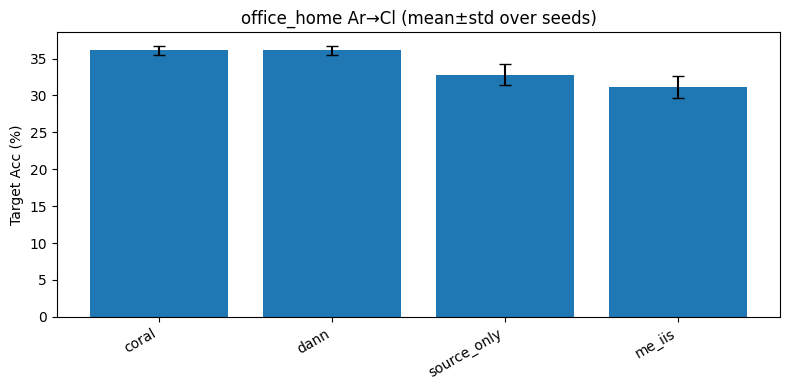

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

from src.experiments.notebook_summary import collect_expected_runs

expected_cfgs = []
for seed in SEEDS:
    expected_cfgs.append(make_cfg("source_only", seed))
    expected_cfgs.append(make_cfg("me_iis", seed, method_params=ME_IIS_PARAMS))
    expected_cfgs.append(make_cfg("dann", seed, method_params=DANN_PARAMS))
    expected_cfgs.append(make_cfg("coral", seed, method_params=CORAL_PARAMS))
    expected_cfgs.append(make_cfg("pseudo_label", seed, method_params=PL_PARAMS))

rows = collect_expected_runs(expected_cfgs, runs_root=RUNS_ROOT)
df = pd.DataFrame(rows)
df["target_acc_num"] = pd.to_numeric(df.get("target_acc"), errors="coerce")
df["target_display"] = df.apply(lambda r: r["target_acc_num"] if r["status"] == "OK" else r["status"], axis=1)

print(f"[Summary] Expected runs: {len(expected_cfgs)}")
display(df[["method", "seed", "status", "source_acc", "target_acc", "run_id", "metrics_csv"]])

pivot = df.pivot(index="method", columns="seed", values="target_display").fillna("NOT RUN")
print("Target accuracy by method x seed (or status):")
display(pivot)

ok = df[df["status"] == "OK"].copy()
if ok.empty:
    print("No successful runs yet.")
else:
    stats = ok.groupby("method")["target_acc_num"].agg(["mean", "std", "count"]).reset_index()
    stats = stats.sort_values("mean", ascending=False)
    stats["std"] = stats["std"].fillna(0.0)
    print("Mean ± std (target_acc over OK runs):")
    display(stats)

    plt.figure(figsize=(8, 4))
    plt.bar(stats["method"], stats["mean"], yerr=stats["std"], capsize=4)
    plt.ylabel("Target Acc (%)")
    plt.title(f"{DATASET_NAME} {SOURCE_DOMAIN}→{TARGET_DOMAIN} (mean±std over seeds)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


## 8) Export artifacts


In [18]:
import pandas as pd
from utils.experiment_utils import dataset_tag
from src.experiments.notebook_summary import collect_expected_runs

expected_cfgs = []
for seed in SEEDS:
    expected_cfgs.append(make_cfg("source_only", seed))
    expected_cfgs.append(make_cfg("me_iis", seed, method_params=ME_IIS_PARAMS))
    expected_cfgs.append(make_cfg("dann", seed, method_params=DANN_PARAMS))
    expected_cfgs.append(make_cfg("coral", seed, method_params=CORAL_PARAMS))
    expected_cfgs.append(make_cfg("pseudo_label", seed, method_params=PL_PARAMS))

rows = collect_expected_runs(expected_cfgs, runs_root=RUNS_ROOT)
df = pd.DataFrame(rows)

ds_tag = dataset_tag(DATASET_NAME)
pair = f"{SOURCE_DOMAIN}2{TARGET_DOMAIN}"
out_dir = RUNS_ROOT / ds_tag / pair
out_dir.mkdir(parents=True, exist_ok=True)

export_path = out_dir / "all_metrics.csv"
df.to_csv(export_path, index=False)
print("[Export] Wrote:", export_path)


[Export] Wrote: /content/drive/MyDrive/ME-IIS/outputs/runs/office-home/Ar2Cl/all_metrics.csv
